In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

def symmetrize(matrix):
    """Symmetrize a triangular matrix."""
    return matrix + matrix.T - np.diag(matrix.diagonal())


# In this notebook, we will analyze the two body interaction within the deuteron. We operate in the realm of ab initio nuclear structure physics and
# want to especially focus on the difference of the relative harmonic oscillator basis vs the relative momentum basis. Especially the problem of 
# convergence in regards to trunctuation and the grid size will be discussed.

# test_data = pd.read_csv(r"C:\Users\Elias Enrique Hamel\Documents\TUDarmstadt\Master\NuclearStructure\code_git\comp_nuclear_structure_physics2025\Data\RelativeHarmonicOscillator\chi2bSMSI5C\chi2bSMSI5C_srg0000_NMax100_LMax02_hwHO010.meho\chi2bSMSI5C_srg0000_NMax100_LMax02_hwHO010.meho", sep = r"\s+", header = None, skiprows = 1)
# test_data = pd.read_csv(r"Data\RelativeHarmonicOscillator\chi2bM3A\chi2bM3A_srg0000_NMax100_LMax02_hwHO012.meho\chi2bM3A_srg0000_NMax100_LMax02_hwHO012.meho",  sep = r"\s+", header = None, skiprows = 1)
test_data = pd.read_csv(r"Data\RelativeHarmonicOscillator\kinetic\trel_NMax100_LMax02_hwHO010.meho\trel_NMax100_LMax02_hwHO010.meho", sep = r"\s+", header = None, skiprows = 1)

test_data = test_data.rename(columns = {0: "N", 1: "L", 2: "N'", 3:"L'", 4:"S", 5:"J", 6: "T", 7:"MT", 8:"E"})

test_data = test_data.loc[(test_data['J'] == 1) & (test_data['S'] == 1) & (test_data['T'] == 0) & (test_data['MT'] == 0)]
test_data = test_data.sort_values(['L',"L'"])

# save the data
test_data.to_csv("test_data.csv")


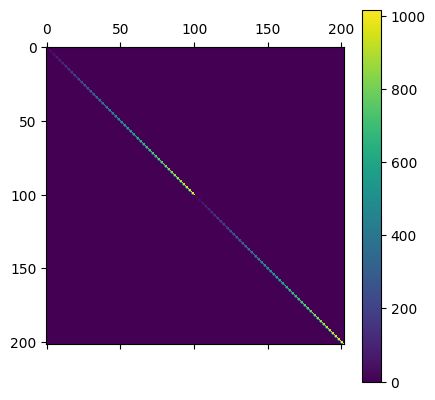

E_20 vs. E_02^T:
True
Is the Hamiltonian Hermitian after symmetrization? False
Unique N values: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]
Unique N' values: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]
Unique L values: [0 2]
Unique L' values: [0 2]


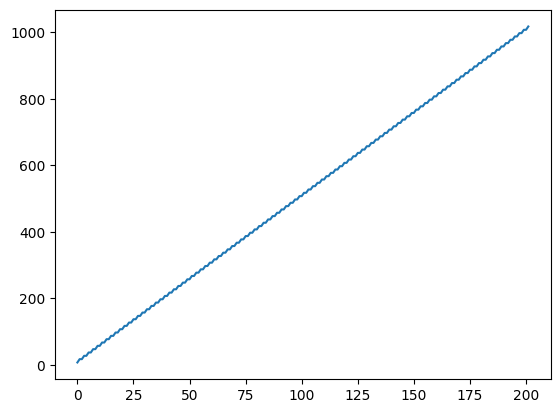

7.5


In [3]:
# Since we especially target the deuteron ground state, we filtered according to all the fixed angular momentum quantum numbers
# We will follow by creating a block diagonal matrix where the upper left inner matrix will be (L=0, L'=0), the upper right (L=0, L'=2) the lower left (L=2,L'=0) and the lower right (L=2;L'=2)


# Extract submatrices
E_00 = test_data[(test_data['L'] == 0) & (test_data["L'"] == 0)].pivot(index="N'", columns="N", values='E').fillna(0).values
E_02 = test_data[(test_data['L'] == 0) & (test_data["L'"] == 2)].pivot(index="N'", columns="N", values='E').fillna(0).values
E_20 = test_data[(test_data['L'] == 2) & (test_data["L'"] == 0)].pivot(index="N'", columns="N", values='E').fillna(0).values
E_22 = test_data[(test_data['L'] == 2) & (test_data["L'"] == 2)].pivot(index="N'", columns="N", values='E').fillna(0).values

# E_00 = symmetrize(E_00)
# E_02 = symmetrize(E_02)
# E_20 = symmetrize(E_20)
# E_22 = symmetrize(E_22)

# Create block diagonal matrix
E_matrix = np.block([[E_00, E_02], [E_20, E_22]])
E_matrix[:E_00.shape[0], E_00.shape[1]:] = E_02
E_matrix[E_00.shape[0]:, :E_00.shape[1]] = E_20

# Plot matrix
plt.matshow(E_matrix)
plt.colorbar()
plt.show()

# Validate symmetry of submatrices
print("E_20 vs. E_02^T:")
print(np.allclose(E_20, E_02.T))

# # Combine submatrices into block Hamiltonian
H = E_matrix
# Check if the Hamiltonian is Hermitian
is_hermitian = np.allclose(H, H.T)
print(f"Is the Hamiltonian Hermitian after symmetrization? {is_hermitian}")


print("Unique N values:", test_data["N"].unique())
print("Unique N' values:", test_data["N'"].unique())
print("Unique L values:", test_data["L"].unique())
print("Unique L' values:", test_data["L'"].unique())

# Since we are interested in the convergence of the relative harmonic oscillator basis, we will plot the eigenvalues of the matrix as a function of the number of basis states
# included in the calculation. We will start with a low number of basis states and increase the number of basis states until we reach a convergence.

# Solve the eigenvalue problem for the entire untrunctated matrix
eigenvalues, eigenvectors = np.linalg.eig(E_matrix)
eigenvalues = np.sort(eigenvalues)
plt.plot(np.abs(eigenvalues))
plt.show()

# print the smallest eigenvalue
print(eigenvalues[0])
#print(eigenvalues)




In [9]:
# We will procede with the momentum basis. We will start by extracting the data from the file and then we will create the block diagonal matrix
# as we did with the relative harmonic oscillator basis. There is a grid for each quantum number J L L' S T MT. 

md_100100 = pd.read_csv(r"Data\RelativeMomentum\chi2bM3A\Grid150\chi2bM3A_srg0000_JLLSTMT10010+0.meq", sep = r"\s+", header = None, skiprows = 9).drop(index=151)
md_102100 = pd.read_csv(r"Data\RelativeMomentum\chi2bM3A\Grid150\chi2bM3A_srg0000_JLLSTMT10210+0.meq", sep = r"\s+", header = None, skiprows = 9).drop(index=151)
md_120100 = pd.read_csv(r"Data\RelativeMomentum\chi2bM3A\Grid150\chi2bM3A_srg0000_JLLSTMT12010+0.meq", sep = r"\s+", header = None, skiprows = 9).drop(index=151)
md_122100 = pd.read_csv(r"Data\RelativeMomentum\chi2bM3A\Grid150\chi2bM3A_srg0000_JLLSTMT12210+0.meq", sep = r"\s+", header = None, skiprows = 9).drop(index=151)


h_momentum = np.block([[md_100100, md_102100], [md_120100, md_122100]]).astype(float)

# create unity matrix of the same size
unity_matrix = np.eye(h_momentum.shape[0])
q = np.arange(0, 10.1, 0.1)
# multiply the first element of the unity matrix with the first element of q and so on
#unity_matrix = unity_matrix*q
for i in range(unity_matrix.shape[0]):
    unity_matrix[i][i] = unity_matrix[i][i]*q[i]
print(unity_matrix)
Tkin = unity_matrix*((197.327)**2/(2*938.272))


# Plot matrix
plt.matshow(h_momentum)
plt.colorbar()
plt.show()

# # Combine submatrices into block Hamiltonian
H_momentum = h_momentum
# Check if the Hamiltonian is Hermitian
is_hermitian = np.allclose(H_momentum, H_momentum.T)
print(f"Is the Hamiltonian Hermitian after symmetrization? {is_hermitian}")

# Solve the eigenvalue problem for the entire untrunctated matrix
eigenvalues_momentum, eigenvectors_momentum = np.linalg.eig(H_momentum)
eigenvalues_momentum = np.sort(eigenvalues_momentum)
plt.plot(np.abs(eigenvalues_momentum))
plt.show()

# print the smallest eigenvalue
print(eigenvalues_momentum[0])
print(eigenvalues_momentum)




KeyboardInterrupt: 